<a href="https://colab.research.google.com/github/8Raouf24/PFE/blob/master/RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import gzip
import matplotlib.pyplot as plt
import json

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz

--2020-07-16 22:31:43--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154050105 (147M) [application/octet-stream]
Saving to: ‘Video_Games_5.json.gz.1’

Video_Games_5.json. 100%[===================>] 146.91M  64.5MB/s    in 2.3s    

2020-07-16 22:31:46 (64.5 MB/s) - ‘Video_Games_5.json.gz.1’ saved [154050105/154050105]



In [ ]:
### load the meta data

data = []
with gzip.open('Video_Games_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

497577
{'overall': 5.0, 'verified': True, 'reviewTime': '10 17, 2015', 'reviewerID': 'A1HP7NVNPFMA4N', 'asin': '0700026657', 'reviewerName': 'Ambrosia075', 'reviewText': "This game is a bit hard to get the hang of, but when you do it's great.", 'summary': "but when you do it's great.", 'unixReviewTime': 1445040000}


In [ ]:
df = pd.DataFrame.from_dict(data)
data_dict = {'userID':df['reviewerID'],'itemID':df['asin'],'rating':df['overall']}
df_rs = pd.DataFrame.from_dict(data_dict)
df = df_rs

print(df_rs.iloc[0])

userID    A1HP7NVNPFMA4N
itemID        0700026657
rating                 5
Name: 0, dtype: object


In [ ]:
user_ids = df_rs["userID"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
item_ids = df_rs["itemID"].unique().tolist()
item2item_encoded = {x: i for i, x in enumerate(item_ids)}
item_encoded2item = {i: x for i, x in enumerate(item_ids)}
df_rs["user"] = df_rs["userID"].map(user2user_encoded)
df_rs["item"] = df_rs["itemID"].map(item2item_encoded)

num_users = len(user2user_encoded)
num_items = len(item_encoded2item)
df_rs["rating"] = df_rs["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df_rs["rating"])
max_rating = max(df_rs["rating"])

print(
    "Number of users: {}, Number of Items: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_items, min_rating, max_rating
    )
)


Number of users: 55223, Number of Items: 17408, Min rating: 1.0, Max rating: 5.0


In [ ]:
df_rs = df_rs.sample(frac=1, random_state=42)
x = df_rs[["user", "item"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df_rs["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.8 * df_rs.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)


In [48]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.item_embedding = layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.item_bias = layers.Embedding(num_items, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.0001),
    metrics=['mse'])

In [49]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(x_val, y_val),
)


Epoch 1/20
6220/6220 [==============================] - 188s 30ms/step - loss: 0.6797 - mse: 0.1740 - val_loss: 0.6567 - val_mse: 0.1632
Epoch 2/20
6220/6220 [==============================] - 182s 29ms/step - loss: 0.5568 - mse: 0.1149 - val_loss: 0.5068 - val_mse: 0.0931
Epoch 3/20
6220/6220 [==============================] - 183s 29ms/step - loss: 0.4886 - mse: 0.0859 - val_loss: 0.5007 - val_mse: 0.0907
Epoch 4/20
6220/6220 [==============================] - 179s 29ms/step - loss: 0.4841 - mse: 0.0845 - val_loss: 0.4967 - val_mse: 0.0891
Epoch 5/20
6220/6220 [==============================] - 179s 29ms/step - loss: 0.4802 - mse: 0.0832 - val_loss: 0.4936 - val_mse: 0.0879
Epoch 6/20
6220/6220 [==============================] - 180s 29ms/step - loss: 0.4768 - mse: 0.0821 - val_loss: 0.4900 - val_mse: 0.0865
Epoch 7/20
6220/6220 [==============================] - 179s 29ms/step - loss: 0.4733 - mse: 0.0809 - val_loss: 0.4878 - val_mse: 0.0857
Epoch 8/20
6220/6220 [===================

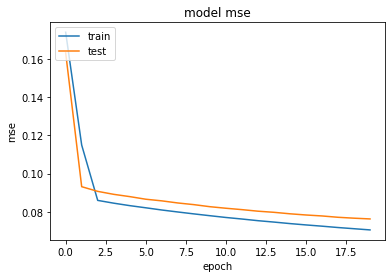

In [51]:
plt.plot(history.history["mse"])
plt.plot(history.history["val_mse"])
plt.title("model mse")
plt.ylabel("mse")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()